# Modeling spike data with `multidms.jaxmodels`

In [213]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

Papermill params

In [214]:
replicate = "lib_1"
# func_score_type = "loose_bottle"
func_score_type = "observed_phenotype"
do_truncate_nonsense = True
output_dir = 'simulations_output'

reference = 'h1'
l2reg = 1e-4
fusionreg = 1.0
block_iters = 50
block_tol = 0

ge_tol = 1e-4
ge_maxiter = 1000
ge_maxls = 30

cal_tol = 1e-4
cal_maxiter = 1000
cal_maxls = 30

loss_fn = "functional_score_loss"
beta_naught_init = {
    "h1": 5.0,
    "h2": 3.41
}
alpha_init = {
    "h1": 6.0,
    "h2": 6.0
}
warmstart = False
beta_clip = (-10, 10)
# loss_fn = "count_loss"

loss_kwargs = {"δ": 1.0}
# loss_kwargs = {}

# global_epistasis = "Identity"
global_epistasis = "Sigmoid"

functional_score_min = -6
functional_score_max = 2
# pseudocount = 0.
min_pre_count = 200
min_post_count = 1

In [215]:
loss_fn = getattr(multidms.jaxmodels, loss_fn)
global_epistasis = getattr(multidms.jaxmodels, global_epistasis)()

In [216]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data loading/filtering

Read raw data, pick replicate, and aggregate counts

In [217]:
df = (
    pd.read_csv(
        "../scaled_down_parameter_output/simulated_functional_scores.csv", 
        keep_default_na=True
    )
    .infer_objects()
    .assign(
        aa_substitutions = lambda x: x['aa_substitutions'].fillna('')
    )
    .assign(
        n_subs = lambda x: x['aa_substitutions'].str.split().str.len()
    )
    .rename(
        columns={
            "library": "replicate",
            "homolog": "condition",
        }
    )
)
df


,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
1,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
2,lib_1,h1,,observed_phenotype,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wildtype,5.000000,0
3,lib_1,h1,L2Q H31*,observed_phenotype,-5.929515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stop,-5.282384,2
4,lib_1,h1,N3Y L17N D18I E27R,observed_phenotype,-5.039159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.707815,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182251,lib_2,h2,N3* L23V M29V,tight_bottle,-6.406314,pre-selection,4.255248,22.0,0.0,690497.0,1301494.0,0.5,3.0,stop,-8.252959,3
182252,lib_2,h2,V39* F45V,tight_bottle,-6.406314,pre-selection,4.255248,22.0,0.0,690497.0,1301494.0,0.5,2.0,stop,-7.193444,2
182253,lib_2,h2,M29S Y38H L44A,tight_bottle,2.159740,pre-selection,0.103493,22.0,189.0,690497.0,1301494.0,0.5,3.0,>1 nonsynonymous,3.096208,3
182254,lib_2,h2,V41N G48V,tight_bottle,-6.043744,pre-selection,4.281678,17.0,0.0,690497.0,1301494.0,0.5,2.0,>1 nonsynonymous,1.074724,2


In [218]:
# # df = pd.read_csv("simulated_bottleneck_cbf.csv", keep_default_na=False)
# df = pd.read_csv("../scaled_down_parameter_output/simulated_bottleneck_cbf.csv", keep_default_na=False)
# # df = pd.read_csv("../scaled_down_parameter_output/simulated_functional_scores.csv", keep_default_na=False)
# df.rename(
#     columns={
#         "library": "replicate",
#         "homolog": "condition",
#         "n_aa_substitutions": "n_subs",
#     },
#     inplace=True,
# )
# df

<Axes: >

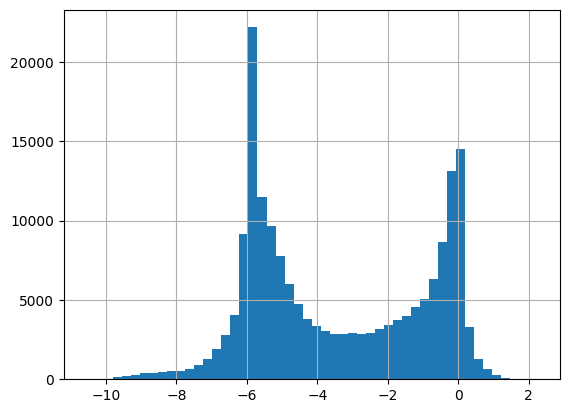

In [219]:
df.func_score.hist(bins=50)

In [220]:
df

,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
1,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
2,lib_1,h1,,observed_phenotype,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wildtype,5.000000,0
3,lib_1,h1,L2Q H31*,observed_phenotype,-5.929515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stop,-5.282384,2
4,lib_1,h1,N3Y L17N D18I E27R,observed_phenotype,-5.039159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.707815,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182251,lib_2,h2,N3* L23V M29V,tight_bottle,-6.406314,pre-selection,4.255248,22.0,0.0,690497.0,1301494.0,0.5,3.0,stop,-8.252959,3
182252,lib_2,h2,V39* F45V,tight_bottle,-6.406314,pre-selection,4.255248,22.0,0.0,690497.0,1301494.0,0.5,2.0,stop,-7.193444,2
182253,lib_2,h2,M29S Y38H L44A,tight_bottle,2.159740,pre-selection,0.103493,22.0,189.0,690497.0,1301494.0,0.5,3.0,>1 nonsynonymous,3.096208,3
182254,lib_2,h2,V41N G48V,tight_bottle,-6.043744,pre-selection,4.281678,17.0,0.0,690497.0,1301494.0,0.5,2.0,>1 nonsynonymous,1.074724,2


In [221]:
df.query(f"replicate == '{replicate}' & func_score_type == '{func_score_type}'", inplace=True)
df

,replicate,condition,aa_substitutions,func_score_type,func_score,pre_sample,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions,variant_class,latent_phenotype,n_subs
0,lib_1,h1,L33P,observed_phenotype,0.008957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 nonsynonymous,5.253866,1
1,lib_1,h1,N3V F16S,observed_phenotype,-0.031679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.413085,2
2,lib_1,h1,,observed_phenotype,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wildtype,5.000000,0
3,lib_1,h1,L2Q H31*,observed_phenotype,-5.929515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stop,-5.282384,2
4,lib_1,h1,N3Y L17N D18I E27R,observed_phenotype,-5.039159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-1.707815,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45556,lib_1,h2,L23S F34V,observed_phenotype,-4.106698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-0.926651,2
45557,lib_1,h2,R13H E27R Y38P,observed_phenotype,-5.602931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-3.339751,3
45558,lib_1,h2,C31R V42C,observed_phenotype,0.150661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,4.978748,2
45559,lib_1,h2,F1K P25D,observed_phenotype,-3.990509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>1 nonsynonymous,-0.833197,2


In [222]:

# remove variants with too many deletions
df = df.loc[df.aa_substitutions.str.count("-") == 0, :]

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum", "func_score": "mean"}
    ).reset_index()

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,0.0,0.0,0.000000
1,h1,lib_1,A10*,1,0.0,0.0,-5.919686
2,h1,lib_1,A10* C26L,2,0.0,0.0,-5.932902
3,h1,lib_1,A10* C26P W40T P43F,4,0.0,0.0,-5.959762
4,h1,lib_1,A10* E27* L33H,3,0.0,0.0,-5.959843
...,...,...,...,...,...,...,...
30432,h2,lib_1,Y47T,1,0.0,0.0,-1.395811
30433,h2,lib_1,Y47T G48S,2,0.0,0.0,-5.799976
30434,h2,lib_1,Y47T L49E,2,0.0,0.0,-4.684547
30435,h2,lib_1,Y47V,1,0.0,0.0,0.013736


In [223]:
df.query("aa_substitutions == ''")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,0.0,0.0,0.0
15204,h2,lib_1,,0,0.0,0.0,0.0


In [224]:
df[df["aa_substitutions"].str.contains("G50W")]

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score


Ah, G50W doesn't hit the threshold.

### Count filtering

Apply some thresholds to filter out low counts. We need pre-counts to be reasonably high to satisfy assumptions of the count-based loss function.

In [225]:
if func_score_type != "observed_phenotype":
    g = sns.relplot(
        x=df.pre_count[df.aa_substitutions != ""],
        y=df.post_count[df.aa_substitutions != ""],
        col=df.condition[df.aa_substitutions != ""],
        s=10, alpha=0.1,
        height=3, aspect=1,
        clip_on=False,
        )
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xscale("symlog", linthresh=1, linscale=0.5)
    plt.yscale("symlog", linthresh=1, linscale=0.5)

    for ax in g.axes.flat:
        condition = ax.get_title().split(" = ")[1]
        df_condition = df.query(f"(condition == @condition) & (aa_substitutions != '')")
        df.drop(index=df_condition.query("(pre_count < @min_pre_count) | (post_count < @min_post_count)").index, inplace=True)
        ax.axvline(min_pre_count, color="red", linestyle="--")
        ax.axhline(min_post_count, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

In [226]:
df.shape

(30437, 7)

### Mutation number filtering

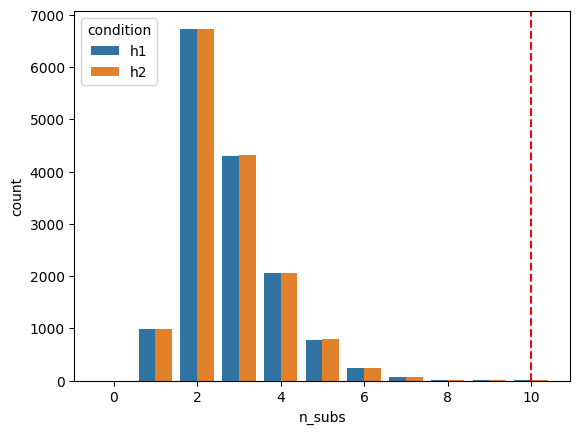

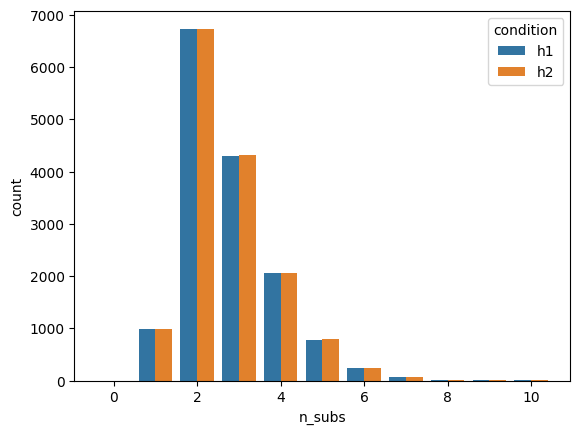

In [227]:
n_sub_thresh = 10

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.axvline(n_sub_thresh, color="red", linestyle="--")
plt.show()

df = df.query("n_subs <= @n_sub_thresh")

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()


In [228]:
df.shape

(30437, 7)

### Nonsense variants

Truncate nonsense variants to exlude any mutations downstream of the first nonsense mutation, and then filter to only nonsense variants with no missense mutation before first nonsense.

In [229]:
# # TEMP: cmopletetely remove nonsense
# df = df.loc[~df.aa_substitutions.str.contains("*", regex=False)]
# df.shape

In [230]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

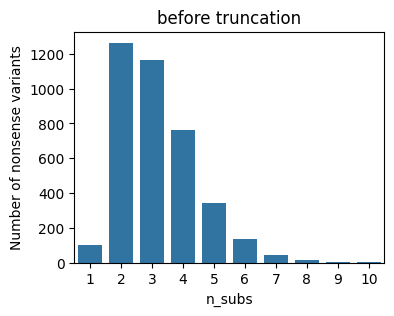

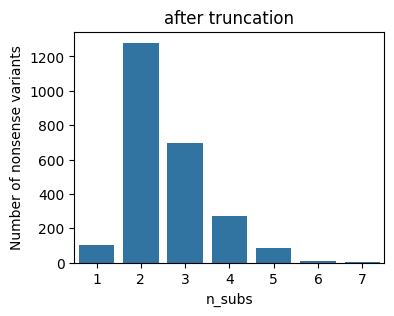

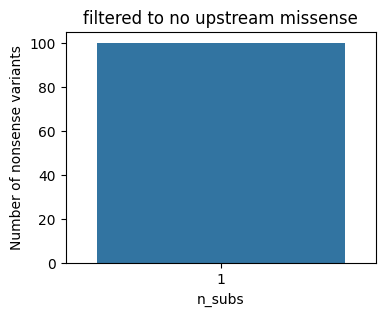

In [231]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

if do_truncate_nonsense:
    df = df.apply(truncate_nonsense, axis=1)
    # re-aggregate identical variants
    df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
        {"n_subs": "first", "pre_count": "sum", "post_count": "sum", "func_score": "mean"}
        ).reset_index()

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("after truncation")
    plt.show()

    df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("filtered to no upstream missense")
    plt.show()

### Compute functional scores

Note: $\log$ is more natural than $\log_2$ in the fitness-based model

/var/folders/3x/xgx592cd1036yjqqj8dnvnsh0000gn/T/ipykernel_5312/702988830.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)


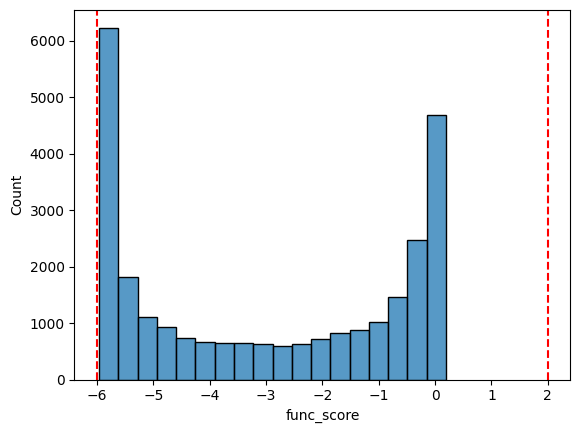

In [232]:
# df["func_score"] = np.log(df["post_count"] + pseudocount) - np.log(df["pre_count"] + pseudocount)

# def group_wt_ref(df_group):
#     wts = df_group.query("aa_substitutions == ''")
#     assert wts.shape[0] == 1, wts
#     df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
#     return df_group

# df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

sns.histplot(df.func_score)
plt.axvline(functional_score_min, color="red", linestyle="--")
plt.axvline(functional_score_max, color="red", linestyle="--")
df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)
plt.show()

<Axes: xlabel='func_score', ylabel='Count'>

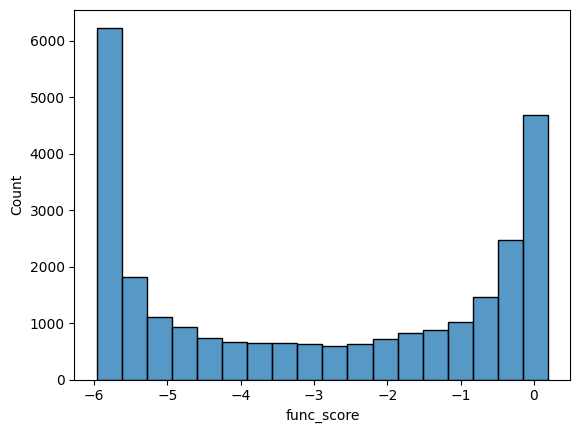

In [233]:
sns.histplot(df.func_score)

### Multidms data

Load as a multidms dataset, choosing a reference condition.

In [234]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference=reference,
)

/Users/macdre/Matsengrp/projects/dms/.pixi/envs/default/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Create a `jaxmodels.Data` object, containing the array data

In [235]:
data_sets = {
    d: multidms.jaxmodels.Data.from_multidms(multidms_data, d)
    for d in multidms_data.conditions
    }

# Display the reference condition data object
data_sets[multidms_data.reference]

Data(
  x_wt=i8[1000],
  X=BCOO(int8[13352, 1000], nse=35624),
  functional_scores=f64[13352],
  pre_count_wt=f64[],
  post_count_wt=f64[],
  pre_counts=f64[13352],
  post_counts=f64[13352]
)

In [236]:
data_sets

{'h1': Data(
   x_wt=i8[1000],
   X=BCOO(int8[13352, 1000], nse=35624),
   functional_scores=f64[13352],
   pre_count_wt=f64[],
   post_count_wt=f64[],
   pre_counts=f64[13352],
   post_counts=f64[13352]
 ),
 'h2': Data(
   x_wt=i8[1000],
   X=BCOO(int8[13354, 1000], nse=161562),
   functional_scores=f64[13354],
   pre_count_wt=f64[],
   post_count_wt=f64[],
   pre_counts=f64[13354],
   post_counts=f64[13354]
 )}

In [237]:
df.query("aa_substitutions == ''    ")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,0.0,0.0,0.0
14524,h2,lib_1,,0,0.0,0.0,0.0


In [238]:
for condition in multidms_data.conditions:
    print(data_sets[condition].pre_count_wt)
    print(data_sets[condition].post_count_wt)


0.0
0.0
0.0
0.0


In [239]:
{d: int(data_sets[d].x_wt.sum()) for d in data_sets}

{'h1': 0, 'h2': 10}

Plot the sums of the binary encodings of the variants

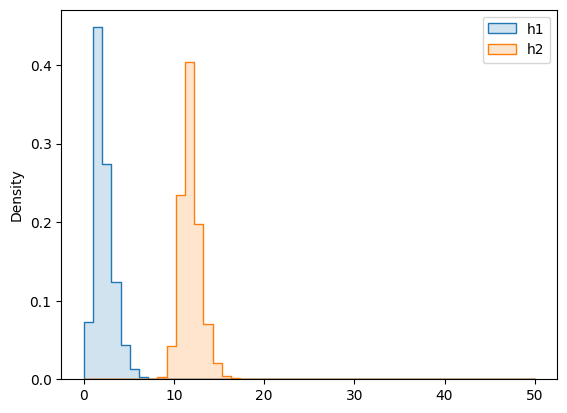

In [240]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

Distribution of functional scores

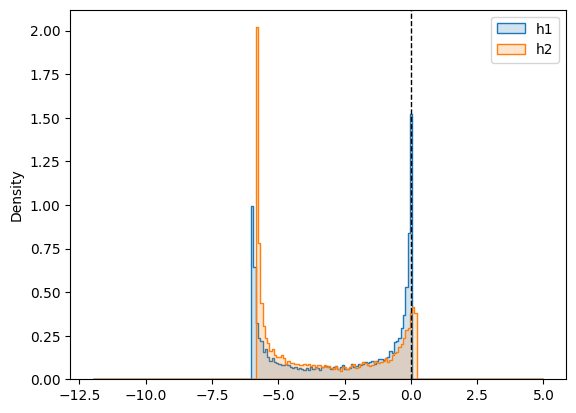

In [241]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

## Fit model

In [242]:
model, loss_trajectory = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg=l2reg,
    fusionreg=fusionreg,
    block_iters=block_iters,
    block_tol=block_tol,
    ge_kwargs=dict(
        tol=ge_tol,
        maxiter=ge_maxiter,
        maxls=ge_maxls,
        jit=True,
        # verbose=False
        ),
    cal_kwargs=dict(
        tol=cal_tol,
        maxiter=cal_maxiter,
        maxls=cal_maxls,
        jit=True,
        # verbose=False
        ),
    loss_fn=loss_fn,
    global_epistasis=global_epistasis,
    loss_kwargs=loss_kwargs,
    warmstart=warmstart,
    beta_naught_init=beta_naught_init,
    beta_clip_range=beta_clip,
    alpha_init=alpha_init
    )

iter 1:
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
    h1: β0=5.00
    h2: β0=3.41
  β_nonbundle: error=4.59e-05, stepsize=8.2e+03, iter=156
  β_bundle: error=9.83e-05, stepsize=8.0e+00, iter=504
  h2 sparsity=69.8%
  obj=3.15e-03
  objective_error=9.97e-01
iter 2:
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
    h1: β0=5.00
    h2: β0=3.41
  β_nonbundle: error=6.93e-05, stepsize=2.0e+03, iter=14
  β_bundle: error=9.99e-05, stepsize=8.0e+00, iter=154
  h2 sparsity=69.4%
  obj=2.85e-03
  objective_error=2.99e-04
iter 3:
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
    h1: β0=5.00
    h2: β0=3.41
  β_nonbundle: error=9.75e-05, stepsize=2.0e+03, iter=11
  β_bundle: error=8.60e-05, stepsize=8.0e+00, iter=43
  h2 sparsity=73.0%
  obj=2.71e-03
  objective_error=1.40e-04
iter 4:
    h1: α=6.00, θ=1.00
    h2: α=6.00, θ=1.00
    h1: β0=5.00
    h2: β0=3.41
  β_nonbundle: error=6.14e-05, stepsize=4.1e+03, iter=12
  β_bundle: error=8.09e-05, stepsize=8.0e+00, iter=46
  h2 sparsity=74.6%
  o

## Loss trajectory

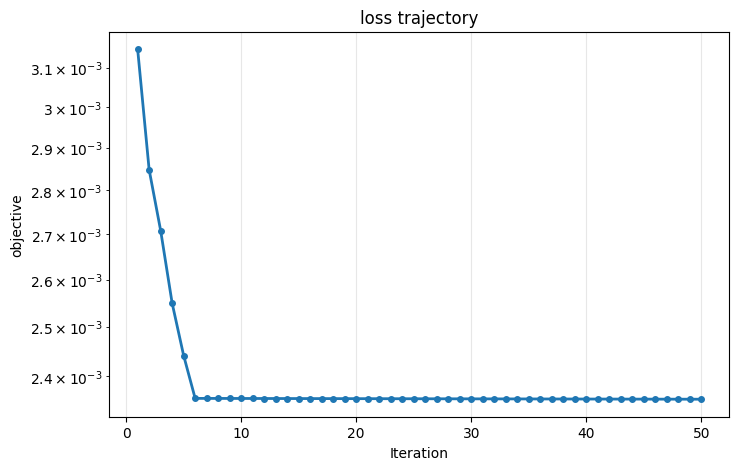

Final loss: 0.002355
Total iterations: 50


In [243]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_trajectory) + 1), loss_trajectory, 'o-', linewidth=2, markersize=4)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title('loss trajectory')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {loss_trajectory[-1]:.6f}")
print(f"Total iterations: {len(loss_trajectory)}")


$\beta$ shift distributions

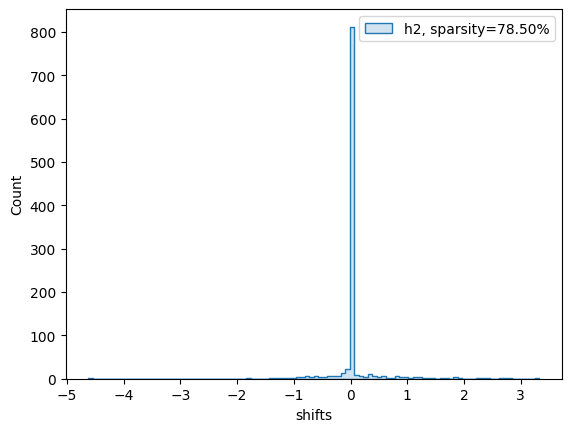

In [244]:
for d in data_sets:
    if d != model.reference_condition:
        shifts = model.φ[d].β - model.φ[model.reference_condition].β
        sns.histplot(
            x=shifts,
            bins=100,
            label=f"{d}, sparsity={(shifts == 0).sum() / len(shifts):.2%}", fill=True, alpha=0.2, element="step")
plt.legend()
plt.xlabel("shifts")
plt.show()

Read in ground truth mut effects

In [245]:
simu_mut_effects = pd.read_csv("../scaled_down_parameter_output/simulated_muteffects.csv", keep_default_na=False)
simu_mut_effects

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,F1A,-2.019912,F,1,A,False,0.0,-2.019912,F,F,False
1,F1C,-0.417888,F,1,C,False,0.0,-0.417888,F,F,False
2,F1D,-2.928096,F,1,D,False,0.0,-2.928096,F,F,False
3,F1E,-1.516192,F,1,E,False,0.0,-1.516192,F,F,False
4,F1G,-4.732575,F,1,G,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...,...,...,...,...
995,E50T,-0.942467,E,50,T,False,0.0,-0.942467,E,E,False
996,E50V,-0.989250,E,50,V,False,0.0,-0.989250,E,E,False
997,E50W,-1.192453,E,50,W,False,0.0,-1.192453,E,E,False
998,E50Y,-3.083547,E,50,Y,False,0.0,-3.083547,E,E,False


Find ground truth sparsity

In [246]:
# how many shifts are equal to zero in simulated mut effects
zero_shift_df = simu_mut_effects[simu_mut_effects["shift"] == 0]
display(zero_shift_df)
(zero_shift_df.shape[0], simu_mut_effects.shape[0], zero_shift_df.shape[0] / simu_mut_effects.shape[0])

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,F1A,-2.019912,F,1,A,False,0.0,-2.019912,F,F,False
1,F1C,-0.417888,F,1,C,False,0.0,-0.417888,F,F,False
2,F1D,-2.928096,F,1,D,False,0.0,-2.928096,F,F,False
3,F1E,-1.516192,F,1,E,False,0.0,-1.516192,F,F,False
4,F1G,-4.732575,F,1,G,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...,...,...,...,...
995,E50T,-0.942467,E,50,T,False,0.0,-0.942467,E,E,False
996,E50V,-0.989250,E,50,V,False,0.0,-0.989250,E,E,False
997,E50W,-1.192453,E,50,W,False,0.0,-1.192453,E,E,False
998,E50Y,-3.083547,E,50,Y,False,0.0,-3.083547,E,E,False


(810, 1000, 0.81)

Functional score correlations

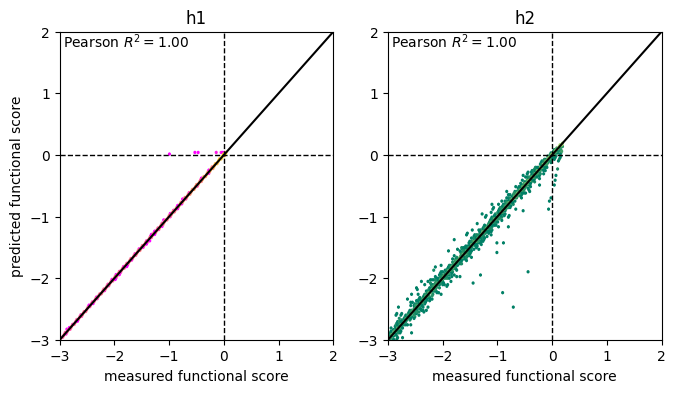

In [247]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], gridsize=200, bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $R^2={scipy.stats.pearsonr(y, y_pred).statistic**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-3, 2)
    plt.ylim(-3, 2)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()

Fitness landscape

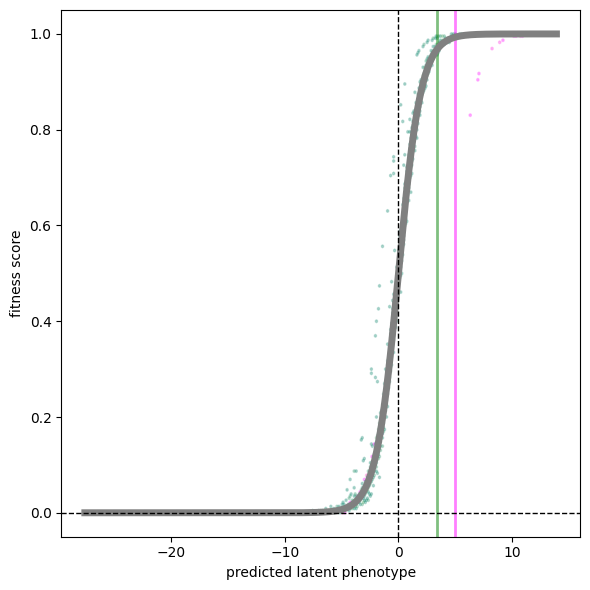

In [248]:
plt.figure(figsize=(6, 6))
φ_min = np.inf
φ_max = -np.inf
for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_min = min(φ_min, φ_pred.min())
    φ_max = max(φ_max, φ_pred.max())
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.global_epistasis(φ(x_wt))
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", gridsize=200, alpha=0.25)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)

# plot the global epistasis function
φ_grid = np.linspace(φ_min, φ_max, 1000)
plt.plot(φ_grid, model.global_epistasis(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
plt.tight_layout()
plt.show()

Joint plots of $\beta$ between conditions

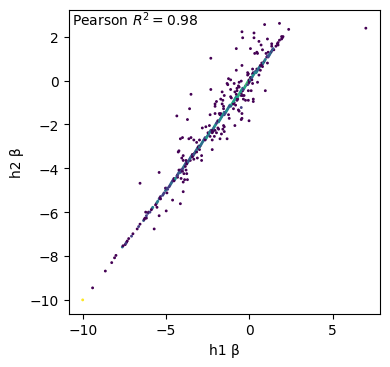

In [249]:
plt.figure(figsize=(4, 7))


plt.subplot(211)
plt.hexbin(model.φ["h1"].β, model.φ["h2"].β, bins="log", gridsize=200)
r = scipy.stats.pearsonr(model.φ["h1"].β, model.φ["h2"].β).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
             fontsize=10,
             xy=(0.01, 0.95), xycoords="axes fraction")
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("h1 β")
plt.ylabel("h2 β")

plt.tight_layout()
plt.show()

In [250]:
model.α

{'h1': Array(6., dtype=float64, weak_type=True),
 'h2': Array(6., dtype=float64, weak_type=True)}

Distribution of $\beta$

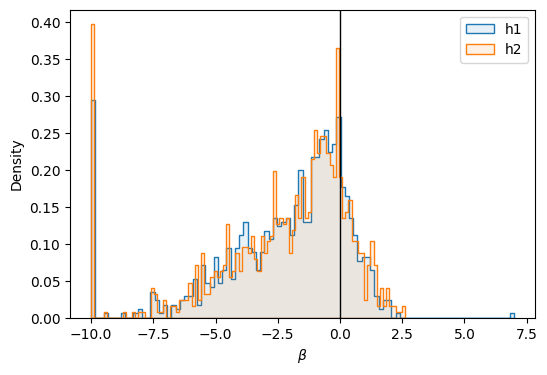

In [251]:
plt.figure(figsize=(6, 4))
for d in model.φ:
    sns.histplot(x=model.φ[d].β, label=d, bins=100, element="step", fill=True, alpha=0.1, stat="density")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()

Compile parameters into dataframe

In [252]:
mutations_df = multidms_data.mutations_df
mutations_df

,mutation,wts,sites,muts,times_seen_h1,times_seen_h2
0,F1A,F,1,A,46,45
1,F1C,F,1,C,20,22
2,F1D,F,1,D,19,19
3,F1E,F,1,E,18,17
4,F1G,F,1,G,55,55
...,...,...,...,...,...,...
995,E50T,E,50,T,55,55
996,E50V,E,50,V,51,50
997,E50W,E,50,W,14,14
998,E50Y,E,50,Y,21,21


In [253]:
len(multidms_data.mutations), data_sets["h1"].X.shape

(1000, (13352, 1000))

In [254]:
for d in multidms_data.conditions:
    # add betas to mut dataframe
    mutations_df[f"beta_{d}"] = model.φ[d].β
    # add shifts to mut dataframe
    if d != multidms_data.reference:
        mutations_df[f"shift_{d}"] = model.φ[d].β - model.φ[multidms_data.reference].β

# mutations_df.to_csv(f"{output_dir}/mutations_df.csv", index=False)
mutations_df = (
    mutations_df
    .drop(["wts", "sites", "muts"], axis=1)
    .set_index("mutation")
)
mutations_df

,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,
F1A,46,45,-2.018180,-2.018180,0.000000
F1C,20,22,-0.418512,-0.418512,0.000000
F1D,19,19,-2.928004,-2.928004,0.000000
F1E,18,17,-1.519553,-1.519553,0.000000
F1G,55,55,-4.732573,-4.732573,0.000000
...,...,...,...,...,...
E50T,55,55,-0.941547,-0.941547,0.000000
E50V,51,50,-0.988161,-0.988161,0.000000
E50W,14,14,-1.193407,-1.193407,0.000000


In [255]:
mutations_df.beta_h1.isna().sum()

np.int64(0)

In [256]:
simu_mut_effects = (
    simu_mut_effects
    .drop(["wt_aa", "site", "mut_aa"], axis=1)
    .set_index("mutation")
    .rename(
        columns={
            "shift": "simulated_shift",
            "beta_h1": "simulated_beta_h1",
            "beta_h2": "simulated_beta_h2"
        }
    )
)
simu_mut_effects

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
mutation,,,,,,,
F1A,-2.019912,False,0.0,-2.019912,F,F,False
F1C,-0.417888,False,0.0,-0.417888,F,F,False
F1D,-2.928096,False,0.0,-2.928096,F,F,False
F1E,-1.516192,False,0.0,-1.516192,F,F,False
F1G,-4.732575,False,0.0,-4.732575,F,F,False
...,...,...,...,...,...,...,...
E50T,-0.942467,False,0.0,-0.942467,E,E,False
E50V,-0.989250,False,0.0,-0.989250,E,E,False
E50W,-1.192453,False,0.0,-1.192453,E,E,False


In [257]:
simu_mut_effects.shape

(1000, 7)

In [258]:
set(simu_mut_effects.index.values) - set(mutations_df.index.values)

set()

In [259]:
# merge the simulated mut effects with the inferred mut effects
merged_df = simu_mut_effects.join(mutations_df, how="inner")
merged_df

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2
mutation,,,,,,,,,,,,
F1A,-2.019912,False,0.0,-2.019912,F,F,False,46,45,-2.018180,-2.018180,0.000000
F1C,-0.417888,False,0.0,-0.417888,F,F,False,20,22,-0.418512,-0.418512,0.000000
F1D,-2.928096,False,0.0,-2.928096,F,F,False,19,19,-2.928004,-2.928004,0.000000
F1E,-1.516192,False,0.0,-1.516192,F,F,False,18,17,-1.519553,-1.519553,0.000000
F1G,-4.732575,False,0.0,-4.732575,F,F,False,55,55,-4.732573,-4.732573,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
E50T,-0.942467,False,0.0,-0.942467,E,E,False,55,55,-0.941547,-0.941547,0.000000
E50V,-0.989250,False,0.0,-0.989250,E,E,False,51,50,-0.988161,-0.988161,0.000000
E50W,-1.192453,False,0.0,-1.192453,E,E,False,14,14,-1.193407,-1.193407,0.000000


In [260]:
merged_df.shape

(1000, 12)

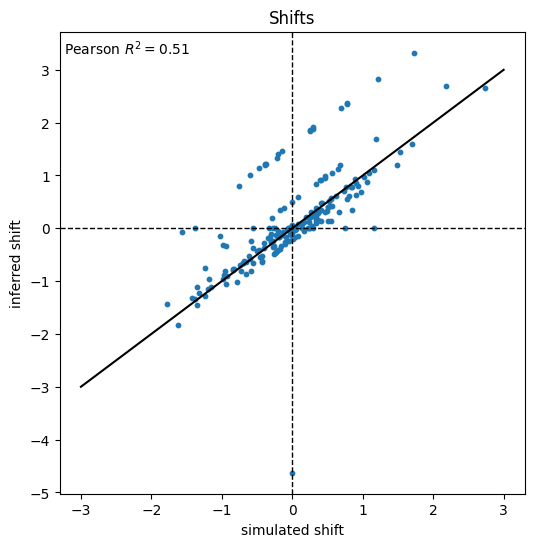

In [261]:
# plot inferred shifts vs simulated shifts for h2
plt.figure(figsize=(6, 6))
x = merged_df["simulated_shift"]
y = merged_df["shift_h2"]
plt.scatter(x, y, alpha=1, s=10)
r = scipy.stats.pearsonr(x, y).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                fontsize=10,
                xy=(0.01, 0.95), xycoords="axes fraction")
plt.plot([-3, 3], [-3, 3], "k")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.xlabel("simulated shift")
plt.ylabel("inferred shift")
plt.title("Shifts")
plt.show()

In [262]:
merged_df = merged_df.assign(abs_shift_error_h2 = (merged_df["simulated_shift"] - merged_df["shift_h2"]).abs())
merged_df.sort_values("abs_shift_error_h2", ascending=False)

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2,abs_shift_error_h2
mutation,,,,,,,,,,,,,
D18Y,2.261674,False,0.000000,2.261674,D,D,False,31,31,6.989857,2.362946,-4.626911,4.626911
R19K,-3.680309,True,0.288440,-3.391869,R,F,False,18,18,-3.682804,-1.764715,1.918090,1.629650
R19Q,-1.626201,True,-0.479023,-2.105224,R,F,False,20,18,-1.625479,-0.490104,1.135375,1.614398
R19Y,0.571894,True,-0.393588,0.178306,R,F,False,26,26,0.570242,1.784083,1.213841,1.607429
R19H,-2.284346,True,0.257128,-2.027218,R,F,False,19,19,-2.285058,-0.421584,1.863473,1.606345
...,...,...,...,...,...,...,...,...,...,...,...,...,...
K21P,0.361932,False,0.000000,0.361932,K,K,False,48,48,0.361683,0.361683,0.000000,0.000000
K21Q,-0.296900,False,0.000000,-0.296900,K,K,False,25,25,-0.297482,-0.297482,0.000000,0.000000
K21R,-2.457307,False,0.000000,-2.457307,K,K,False,84,84,-2.456766,-2.456766,0.000000,0.000000


In [267]:
merged_df = merged_df.assign(abs_beta_error_h2 = (merged_df["simulated_beta_h2"] - merged_df["beta_h2"]).abs())
merged_df.sort_values("abs_beta_error_h2", ascending=False)

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,beta_h2,shift_h2,abs_shift_error_h2,abs_beta_error_h2
mutation,,,,,,,,,,,,,,
R19K,-3.680309,True,0.288440,-3.391869,R,F,False,18,18,-3.682804,-1.764715,1.918090,1.629650,1.627154
R19Q,-1.626201,True,-0.479023,-2.105224,R,F,False,20,18,-1.625479,-0.490104,1.135375,1.614398,1.615119
R19Y,0.571894,True,-0.393588,0.178306,R,F,False,26,26,0.570242,1.784083,1.213841,1.607429,1.605777
R19H,-2.284346,True,0.257128,-2.027218,R,F,False,19,19,-2.285058,-0.421584,1.863473,1.606345,1.605634
R19C,-6.567667,True,0.253394,-6.314273,R,F,False,22,28,-6.557853,-4.709650,1.848203,1.594809,1.604623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N30D,-1.211273,False,0.000000,-1.211273,N,N,False,36,35,-1.211276,-1.211276,0.000000,0.000000,0.000004
H24Q,-2.608569,False,0.000000,-2.608569,H,H,False,29,28,-2.608572,-2.608572,0.000000,0.000000,0.000003
F1G,-4.732575,False,0.000000,-4.732575,F,F,False,55,55,-4.732573,-4.732573,0.000000,0.000000,0.000002


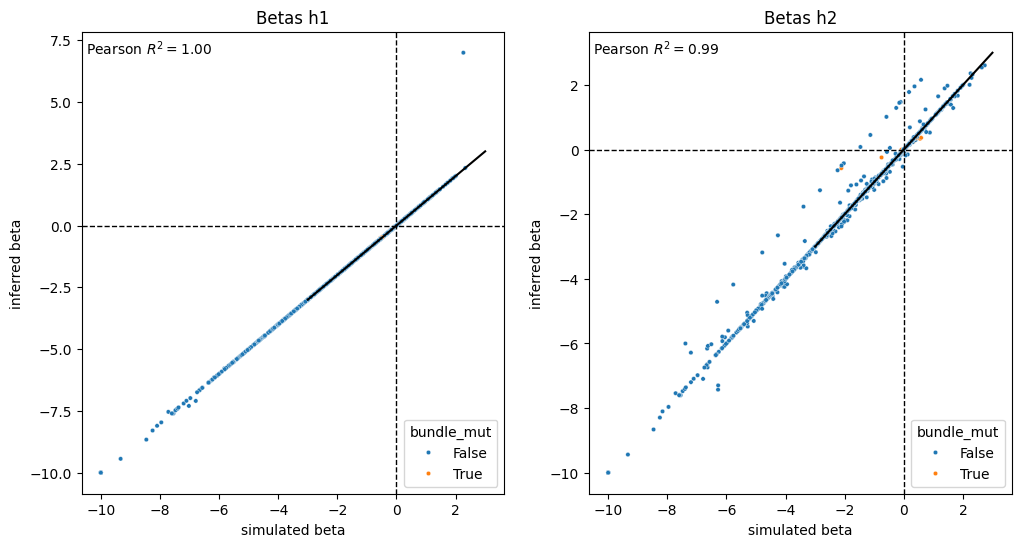

In [264]:
# plot inferred betas vs simulated betas for both h1 and h2
plt.figure(figsize=(12, 6))
for i, d in enumerate(["h1", "h2"]):
    plt.subplot(1, 2, i + 1)
    x = merged_df[f"simulated_beta_{d}"]
    y = merged_df[f"beta_{d}"]
    # plt.scatter(x, y, alpha=1, s=10)
    sns.scatterplot(merged_df, x=f"simulated_beta_{d}", y=f"beta_{d}", alpha=1, s=10, hue="bundle_mut")
    r = scipy.stats.pearsonr(x, y).statistic
    plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-3, 3], [-3, 3], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    # plt.xlim(-3, 3)
    # plt.ylim(-3, 3)
    plt.xlabel("simulated beta")
    plt.ylabel("inferred beta")
    plt.title(f"Betas {d}")

In [265]:
# seaborn scatterplor